In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
warnings.filterwarnings("ignore")

import glob
import shutil
import itertools
import os
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random

from scipy.stats import norm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import sklearn.metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.utils import resample, shuffle

from pairs_trading_package.clustering import *

cwd = os.getcwd()

np.set_printoptions(threshold=sys.maxsize)


from pairs_trading_package.pairs_trading_backtester import (
    SeriesAnalyser, DataProcessor
)
data_processor = DataProcessor()

# ################################################


from multiprocessing import Pool
import tqdm
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
import networkx as nx

Total of 59 tickers
Total of 59 tickers after removing tickers with Nan values


## Marti, G., 2020, May. Corrgan: Sampling realistic financial correlation matrices using generative adversarial networks. In ICASSP 2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP) (pp. 8459-8463). IEEE.

The features extracted from a given correlation matrix:

- Correlation coefficients distribution (mean, std, quantiles, min, max)
- Percentage of variance explained by the k-first eigenvalues, and by the eigenvalues above the Marchenko–Pastur law upper bound of its support
- First eigenvector summary statistics of its entries (mean, std, quantiles, min, max)
- Minimum Spanning Tree (MST) statistics based on shortest paths such as nodes’ closeness centrality, and average shortest path length
- Cophenetic correlation coefficient
- Condition number

These features aim at capturing several important properties of the correlation matrix:

- how strong the correlation is (e.g. correlation coefficients mean, first eigenvalue),
- how diverse the correlation can be (e.g. correlation coefficients std, first eigenvector std),
- how hierarchical the correlation structure is (e.g. cophenetic correlation)
- how complex and interconnected the system is (e.g. MST centrality quantiles and average shortest path length).

## Papenbrock, J., Schwendner, P., Jaeger, M. and Krügel, S., 2021. Matrix evolutions: synthetic correlations and explainable machine learning for constructing robust investment portfolios. The Journal of Financial Data Science, 3(2), pp.51-69.

- eigen_gini: The Gini coefficient of the eigenvalues (Gini ranges from 0 to 1, where 0 means complete equality).
- perron_frob_sum_neg: This measures the sum of negative entries of the first eigenvector.

In [118]:
def get_descriptive_statistics(prefix, descriptive_series, feature_df):
    
    for stat in descriptive_series.index[1:]:
        feature_df[prefix + f'_{stat}'] = descriptive_series[stat]
        
    return feature_df

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    
    array = array.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))).real #Gini coefficient


def compute_graph_stats(nx_graph, graph_type='mst'):

    features = pd.Series()
    features[graph_type + '_edges'] = nx_graph.number_of_edges()
    features[graph_type + '_avg_shortest'] = nx.average_shortest_path_length(nx_graph)
    features[graph_type + '_average_node_connectivity'] = nx.average_node_connectivity(nx_graph)
    
    weights = []
    for node1, node2, weight in nx_graph.edges(data=True):
        weights.append(round(weight['weight'], 4))
    features[graph_type + '_normalised_tree_length'] = (sum(weights)/(len(weights)))

    closeness_centrality = (pd.Series(list(nx.closeness_centrality(nx_graph).values())).describe())
    features = get_descriptive_statistics(graph_type + '_closeness_centrality', closeness_centrality, features)
    
    return features

def compute_mst_stats(corr):
    G = nx.from_numpy_matrix(corr) 
    mst = nx.minimum_spanning_tree(G)
    
    return compute_graph_stats(mst, 'mst')


def compute_features_from_correl(model_corr_df):
    model_corr = np.array(model_corr_df)
    n = len(model_corr)
    a, b = np.triu_indices(n, k=1)
  
    features = pd.Series()
    coefficients = model_corr[a, b].flatten()

    coeffs = pd.Series(coefficients)
    coeffs_stats = coeffs.describe()

    features = get_descriptive_statistics('corr_coeffs', coeffs_stats, features)
        
    features['corr_coeffs_1%'] = coeffs.quantile(q=0.01)
    features['corr_coeffs_99%'] = coeffs.quantile(q=0.99)
    features['corr_coeffs_10%'] = coeffs.quantile(q=0.1)
    features['corr_coeffs_90%'] = coeffs.quantile(q=0.9)
    features['corr_coeffs_99-90'] = features['corr_coeffs_99%'] - features['corr_coeffs_90%']
    features['corr_coeffs_10-1'] = features['corr_coeffs_10%'] - features['corr_coeffs_1%']

    # eigenvals
    eigenvals, eigenvecs = np.linalg.eig(model_corr)
    permutation = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[permutation]
    eigenvecs = eigenvecs[:, permutation]
    
    features['corr_eigen_gini'] = gini(eigenvals)

    pf_vector = eigenvecs[:, np.argmax(eigenvals)]
    if len(pf_vector[pf_vector < 0]) > len(pf_vector[pf_vector > 0]):
        pf_vector = -pf_vector

    features['corr_varex_eig1'] = float(eigenvals[0] / sum(eigenvals))
    features['corr_varex_eig_top5'] = (float(sum(eigenvals[:5])) / float(sum(eigenvals)))
    features['corr_varex_eig_top30'] = (float(sum(eigenvals[:30])) / float(sum(eigenvals)))
    features['corr_varex_5-1'] = (features['corr_varex_eig_top5'] - features['corr_varex_eig1'])
    features['corr_varex_30-5'] = (features['corr_varex_eig_top30'] - features['corr_varex_eig_top5'])
    
    # Marcenko-Pastur (RMT)
    T, N = 252, n # 19391, n
    MP_cutoff = (1 + np.sqrt(N / T))**2
    # variance explained by eigenvals outside of the MP distribution
    features['corr_varex_eig_MP'] = (float(sum([e for e in eigenvals if e > MP_cutoff])) / float(sum(eigenvals)))
    
    # determinant
    features['corr_determinant'] = np.prod(eigenvals)
    
    # condition number
    features['corr_condition_number'] = abs(eigenvals[0]) / abs(eigenvals[-1])

    # stats of the first eigenvector entries
    pf_stats = pd.Series(pf_vector).describe()
    for stat in pf_stats.index[1:]:
        features[f'pf_{stat}'] = float(pf_stats[stat])

    # stats on the MST
    dist = np.sqrt(2 * (1 - model_corr))
    features = pd.concat([features, compute_mst_stats(dist)], axis=0)
    
    # stats on the linkage
    for algo in ['single', 'complete', 'average']:
        Z = fastcluster.linkage(dist[a, b], method=algo)
        features[f'corr_coph_{algo}'] = cophenet(Z, dist[a, b])[0]
        
    return features.sort_index()


In [107]:


def compute_dataset_features(mats, fn):
    p = Pool(3)
    
    all_features = p.imap(fn,
                          tqdm.tqdm([mats[i]
                                     for i in range(len(mats))]))

    p.close()
    p.join()
    return pd.concat(all_features, axis=1).T


In [87]:
import statsmodels.api as sm
from scipy import stats
rng = np.random.default_rng()

def get_sharpe_distribution_from_collated_returns(returns, rf_rate=0.01):
    
    annualized_ret = returns.mean()*252
    vol = returns.std()*np.sqrt(252)

    rf_daily = (1+rf_rate)**(1/252)-1

    sharpe_ratio_assuming_iid = (annualized_ret-rf_daily) /vol
    
    return sharpe_ratio_assuming_iid

def generate_ts_features(df_returns):
    features = {}
    
    equally_weighted_benchmark = df_returns.mean(axis=1)
    
    acf_desc = pd.Series(sm.tsa.acf(equally_weighted_benchmark)).describe()
    
    features.update( get_descriptive_statistics('acf', acf_desc, features) )
    
    features.update( get_descriptive_statistics('returns', equally_weighted_benchmark.describe(), features) )
    
    features['sharpe_benchmark'] = get_sharpe_distribution_from_collated_returns(equally_weighted_benchmark)
    
    features['is_normal'] = int(stats.shapiro(equally_weighted_benchmark)[1] > 0.05)
    
    return pd.Series(features)

In [90]:

splits = [[('2009-10-20', '2011-10-20'), ('2011-10-21', '2012-10-22'), '2010-10-20'],
 [('2014-03-07', '2016-03-07'), ('2016-03-08', '2017-03-08'), '2015-03-09'],
 [('2009-08-10', '2011-08-10'), ('2011-08-11', '2012-08-13'), '2010-08-10'],
 [('2009-08-17', '2011-08-17'), ('2011-08-18', '2012-08-20'), '2010-08-17'],
 [('2011-05-06', '2013-05-06'), ('2013-05-07', '2014-05-07'), '2012-05-07'],
 [('2013-06-12', '2015-06-12'), ('2015-06-15', '2016-06-13'), '2014-06-12'],
 [('2014-07-24', '2016-07-25'), ('2016-07-25', '2017-07-25'), '2015-07-24'],
 [('2011-12-09', '2013-12-09'), ('2013-12-10', '2014-12-10'), '2012-12-10'],
 [('2009-05-20', '2011-05-20'), ('2011-05-23', '2012-05-21'), '2010-05-20'],
 [('2010-05-03', '2012-05-03'), ('2012-05-04', '2013-05-06'), '2011-05-03'],
 [('2010-04-19', '2012-04-19'), ('2012-04-20', '2013-04-22'), '2011-04-19'],
 [('2013-06-07', '2015-06-08'), ('2015-06-08', '2016-06-08'), '2014-06-09'],
 [('2012-04-30', '2014-04-30'), ('2014-05-01', '2015-05-01'), '2013-04-30'],
 [('2012-09-20', '2014-09-22'), ('2014-09-22', '2015-09-21'), '2013-09-20'],
 [('2014-06-17', '2016-06-17'), ('2016-06-20', '2017-06-19'), '2015-06-17'],
 [('2009-06-22', '2011-06-22'), ('2011-06-23', '2012-06-25'), '2010-06-22'],
 [('2011-06-28', '2013-06-28'), ('2013-07-01', '2014-06-30'), '2012-06-28'],
 [('2010-07-20', '2012-07-20'), ('2012-07-23', '2013-07-22'), '2011-07-20'],
 [('2014-05-28', '2016-05-30'), ('2016-05-30', '2017-05-29'), '2015-05-28'],
 [('2014-04-28', '2016-04-28'), ('2016-04-29', '2017-05-01'), '2015-04-28'],
 [('2010-08-19', '2012-08-20'), ('2012-08-20', '2013-08-20'), '2011-08-19'],
 [('2012-06-07', '2014-06-09'), ('2014-06-09', '2015-06-08'), '2013-06-07'],
 [('2014-03-12', '2016-03-14'), ('2016-03-14', '2017-03-13'), '2015-03-12'],
 [('2013-01-10', '2015-01-12'), ('2015-01-12', '2016-01-11'), '2014-01-10'],
 [('2013-03-21', '2015-03-23'), ('2015-03-23', '2016-03-22'), '2014-03-21'],
 [('2012-10-17', '2014-10-17'), ('2014-10-20', '2015-10-19'), '2013-10-17'],
 [('2014-01-30', '2016-02-01'), ('2016-02-01', '2017-01-31'), '2015-01-30'],
 [('2010-11-24', '2012-11-26'), ('2012-11-26', '2013-11-25'), '2011-11-24'],
 [('2011-05-05', '2013-05-06'), ('2013-05-06', '2014-05-06'), '2012-05-07'],
 [('2010-08-30', '2012-08-30'), ('2012-08-31', '2013-09-02'), '2011-08-30'],
 [('2013-02-12', '2015-02-12'), ('2015-02-13', '2016-02-15'), '2014-02-12'],
 [('2011-06-02', '2013-06-03'), ('2013-06-03', '2014-06-03'), '2012-06-04'],
 [('2009-08-07', '2011-08-08'), ('2011-08-08', '2012-08-08'), '2010-08-09'],
 [('2010-05-18', '2012-05-18'), ('2012-05-21', '2013-05-20'), '2011-05-18'],
 [('2012-08-31', '2014-09-01'), ('2014-09-01', '2015-09-01'), '2013-09-02'],
 [('2009-10-16', '2011-10-17'), ('2011-10-17', '2012-10-17'), '2010-10-18'],
 [('2009-07-27', '2011-07-27'), ('2011-07-28', '2012-07-30'), '2010-07-27'],
 [('2013-08-09', '2015-08-10'), ('2015-08-10', '2016-08-10'), '2014-08-11'],
 [('2010-03-09', '2012-03-09'), ('2012-03-12', '2013-03-11'), '2011-03-09'],
 [('2012-04-19', '2014-04-21'), ('2014-04-21', '2015-04-20'), '2013-04-19'],
 [('2009-12-30', '2011-12-30'), ('2012-01-02', '2012-12-31'), '2010-12-30'],
 [('2012-11-16', '2014-11-17'), ('2014-11-17', '2015-11-17'), '2013-11-18'],
 [('2012-05-25', '2014-05-26'), ('2014-05-26', '2015-05-26'), '2013-05-27'],
 [('2011-03-24', '2013-03-25'), ('2013-03-25', '2014-03-25'), '2012-03-26'],
 [('2011-02-28', '2013-02-28'), ('2013-03-01', '2014-03-03'), '2012-02-28'],
 [('2014-09-29', '2016-09-29'), ('2016-09-30', '2017-10-02'), '2015-09-29'],
 [('2011-03-29', '2013-03-29'), ('2013-04-01', '2014-03-31'), '2012-03-29'],
 [('2009-09-22', '2011-09-22'), ('2011-09-23', '2012-09-24'), '2010-09-22'],
 [('2009-01-06', '2011-01-06'), ('2011-01-07', '2012-01-09'), '2010-01-06'],
 [('2009-03-13', '2011-03-14'), ('2011-03-14', '2012-03-14'), '2010-03-15'],
 [('2011-02-23', '2013-02-25'), ('2013-02-25', '2014-02-24'), '2012-02-23'],
 [('2011-01-03', '2013-01-03'), ('2013-01-04', '2014-01-06'), '2012-01-03'],
 [('2012-01-17', '2014-01-17'), ('2014-01-20', '2015-01-19'), '2013-01-17'],
 [('2011-11-09', '2013-11-11'), ('2013-11-11', '2014-11-10'), '2012-11-09'],
 [('2013-11-08', '2015-11-09'), ('2015-11-09', '2016-11-09'), '2014-11-10'],
 [('2012-04-06', '2014-04-07'), ('2014-04-07', '2015-04-07'), '2013-04-08'],
 [('2009-06-05', '2011-06-06'), ('2011-06-06', '2012-06-06'), '2010-06-07'],
 [('2011-04-07', '2013-04-08'), ('2013-04-08', '2014-04-08'), '2012-04-09'],
 [('2012-02-23', '2014-02-24'), ('2014-02-24', '2015-02-24'), '2013-02-25'],
 [('2011-10-19', '2013-10-21'), ('2013-10-21', '2014-10-20'), '2012-10-19'],
 [('2010-10-22', '2012-10-22'), ('2012-10-23', '2013-10-23'), '2011-10-24'],
 [('2010-11-12', '2012-11-12'), ('2012-11-13', '2013-11-13'), '2011-11-14'],
 [('2013-03-14', '2015-03-16'), ('2015-03-16', '2016-03-15'), '2014-03-14'],
 [('2010-12-15', '2012-12-17'), ('2012-12-17', '2013-12-16'), '2011-12-15'],
 [('2010-08-05', '2012-08-06'), ('2012-08-06', '2013-08-06'), '2011-08-05'],
 [('2013-01-14', '2015-01-14'), ('2015-01-15', '2016-01-15'), '2014-01-14'],
 [('2012-08-15', '2014-08-15'), ('2014-08-18', '2015-08-17'), '2013-08-15'],
 [('2009-12-29', '2011-12-29'), ('2011-12-30', '2012-12-31'), '2010-12-29'],
 [('2014-04-08', '2016-04-08'), ('2016-04-11', '2017-04-10'), '2015-04-08'],
 [('2012-09-17', '2014-09-17'), ('2014-09-18', '2015-09-18'), '2013-09-17'],
 [('2010-09-09', '2012-09-10'), ('2012-09-10', '2013-09-10'), '2011-09-09'],
 [('2013-09-10', '2015-09-10'), ('2015-09-11', '2016-09-12'), '2014-09-10']]

ts_features = []
corr_matrices = []

for split in splits:
    
    if pd.to_datetime(split[0][0]) < pd.to_datetime('2012-01-01'):
        df_prices = pd.read_pickle('../data_folder/original/commodity_ETFs_intraday_interpolated_screened_no_outliers.pickle') 
    else:
        df_prices = pd.read_pickle('../data_folder/original/commodity_ETFs_from_2014_complete.pickle')

    # split data in training and test
    df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                                split[0],
                                                                split[1],
                                                                remove_nan=True)

    df_returns = data_processor.get_return_series(df_prices_train.resample('B', label='right', closed='right').last().dropna())
    
    ### TS
    
    ts_features.append(generate_ts_features(df_returns))
    
    ### COR
    
    corr_matrices.append( df_returns.corr(method="pearson") )

Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 116 tickers
Total of 110 tickers after removing tickers with Nan values
Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 59 tickers
Total of 58 tickers after removing tickers with Nan values
Total of 116 tickers
Total of 110 tickers after removing tickers with Nan values
Total of 116 tickers
Total of 102 tickers af

In [120]:
corr_features = compute_dataset_features(np.array(corr_matrices), compute_features_from_correl)

feature_dataset_df = pd.concat([corr_features, pd.DataFrame(ts_features)], axis=1)

100%|██████████| 72/72 [00:01<00:00, 38.30it/s]


In [128]:
from pairs_trading_package.utils import flatten

array_like_split = []

for split in splits:
    array_like_split.append(flatten([flatten(split[:2]), [split[2]]]))
    
array_like_df = pd.DataFrame(array_like_split, columns=['train_start', 'train_end', 'test_start', 'test_end', 'validation_date'])

array_like_df

,train_start,train_end,test_start,test_end,validation_date
0,2009-10-20,2011-10-20,2011-10-21,2012-10-22,2010-10-20
1,2014-03-07,2016-03-07,2016-03-08,2017-03-08,2015-03-09
2,2009-08-10,2011-08-10,2011-08-11,2012-08-13,2010-08-10
3,2009-08-17,2011-08-17,2011-08-18,2012-08-20,2010-08-17
4,2011-05-06,2013-05-06,2013-05-07,2014-05-07,2012-05-07
...,...,...,...,...,...
67,2009-12-29,2011-12-29,2011-12-30,2012-12-31,2010-12-29
68,2014-04-08,2016-04-08,2016-04-11,2017-04-10,2015-04-08
69,2012-09-17,2014-09-17,2014-09-18,2015-09-18,2013-09-17
70,2010-09-09,2012-09-10,2012-09-10,2013-09-10,2011-09-09


In [ ]:
final_df = pd.concat([array_like_df, feature_dataset_df], axis=1)

final_df.to_csv('./market_features.csv')

# Visualization

In [5]:
import pandas as pd
market_feat_df = pd.read_csv('./market_features.csv').iloc[:,1:]

# market_feat_df.sort_values(by='train_start')

market_feat_df['train_start'] = pd.to_datetime(market_feat_df['train_start'])
market_feat_df.set_index('train_start', inplace=True, drop=True)

# market_feat_df

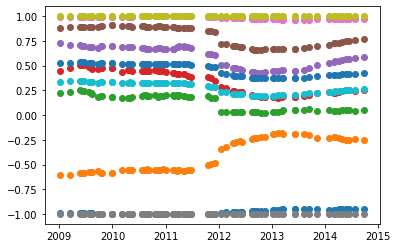

In [6]:
import matplotlib.pyplot as plt

plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_1%'], label='corr_coeffs_1%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_10%'], label='corr_coeffs_10%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_25%'], label='corr_coeffs_25%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_50%'], label='corr_coeffs_50%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_75%'], label='corr_coeffs_75%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_90%'], label='corr_coeffs_90%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_99%'], label='corr_coeffs_99%')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_min'], label='corr_coeffs_min')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_max'], label='corr_coeffs_max')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_mean'], label='corr_coeffs_mean')
plt.scatter(market_feat_df.index, market_feat_df['corr_coeffs_std'], label='corr_coeffs_std')
# plt.legend()
plt.show()

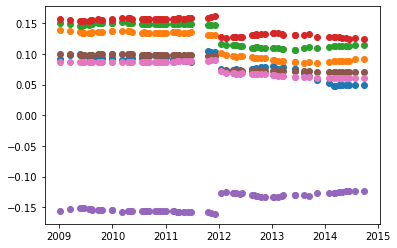

In [50]:

plt.scatter(market_feat_df.index, market_feat_df['pf_25%'], label='pf_25%')
plt.scatter(market_feat_df.index, market_feat_df['pf_50%'], label='pf_50%')
plt.scatter(market_feat_df.index, market_feat_df['pf_75%'], label='pf_75%')
plt.scatter(market_feat_df.index, market_feat_df['pf_max'], label='pf_max')
plt.scatter(market_feat_df.index, market_feat_df['pf_min'], label='pf_min')
plt.scatter(market_feat_df.index, market_feat_df['pf_mean'], label='pf_mean')
plt.scatter(market_feat_df.index, market_feat_df['pf_std'], label='pf_std')
# plt.legend()
plt.show()

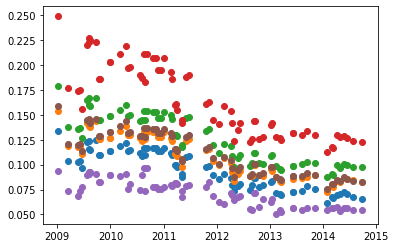

In [18]:

plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_25%'], label='mst_closeness_centrality_25%')
plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_50%'], label='mst_closeness_centrality_50%')
plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_75%'], label='mst_closeness_centrality_75%')
plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_max'], label='mst_closeness_centrality_max')
plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_min'], label='mst_closeness_centrality_min')
plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_mean'], label='mst_closeness_centrality_mean')
# plt.scatter(market_feat_df.index, market_feat_df['mst_closeness_centrality_std'], label='mst_closeness_centrality_std')
# plt.legend()
plt.show()

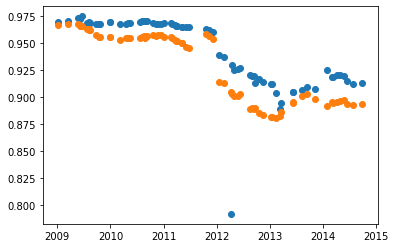

In [43]:


# plt.scatter(market_feat_df.index, market_feat_df['corr_condition_number'], label='corr_condition_number')
# plt.scatter(market_feat_df.index, market_feat_df['corr_coph_average'], label='corr_coph_average')
plt.scatter(market_feat_df.index, market_feat_df['corr_coph_complete'], label='corr_coph_complete')
plt.scatter(market_feat_df.index, market_feat_df['corr_coph_single'], label='corr_coph_single')
# plt.scatter(market_feat_df.index, market_feat_df['corr_determinant'], label='corr_determinant')
# plt.scatter(market_feat_df.index, market_feat_df['corr_eigen_gini'], label='corr_eigen_gini')

# plt.legend()
plt.show()

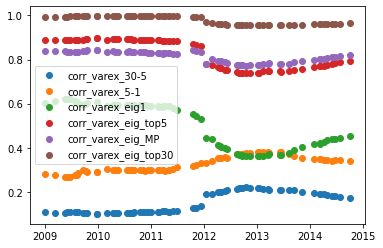

In [33]:

plt.scatter(market_feat_df.index, market_feat_df['corr_varex_30-5'], label='corr_varex_30-5')
plt.scatter(market_feat_df.index, market_feat_df['corr_varex_5-1'], label='corr_varex_5-1')
plt.scatter(market_feat_df.index, market_feat_df['corr_varex_eig1'], label='corr_varex_eig1')
plt.scatter(market_feat_df.index, market_feat_df['corr_varex_eig_top5'], label='corr_varex_eig_top5')
plt.scatter(market_feat_df.index, market_feat_df['corr_varex_eig_MP'], label='corr_varex_eig_MP')
plt.scatter(market_feat_df.index, market_feat_df['corr_varex_eig_top30'], label='corr_varex_eig_top30')

plt.legend()
plt.show()

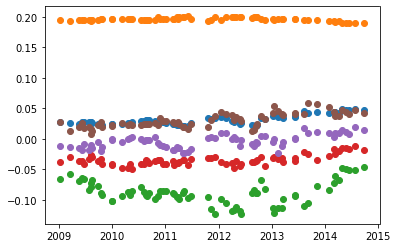

In [30]:
   

plt.scatter(market_feat_df.index, market_feat_df['acf_mean'], label='acf_mean')
plt.scatter(market_feat_df.index, market_feat_df['acf_std'], label='acf_std')
plt.scatter(market_feat_df.index, market_feat_df['acf_min'], label='acf_min')
plt.scatter(market_feat_df.index, market_feat_df['acf_25%'], label='acf_25%')
plt.scatter(market_feat_df.index, market_feat_df['acf_50%'], label='acf_50%')
plt.scatter(market_feat_df.index, market_feat_df['acf_75%'], label='acf_75%')
# plt.scatter(market_feat_df.index, market_feat_df['acf_max'], label='acf_max')

# plt.legend()
plt.show()

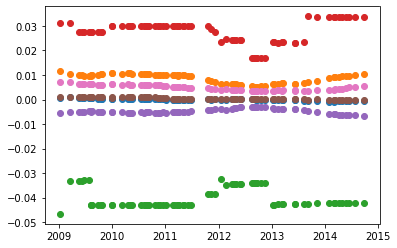

In [29]:

plt.scatter(market_feat_df.index, market_feat_df['returns_mean'], label='returns_mean')
plt.scatter(market_feat_df.index, market_feat_df['returns_std'], label='returns_std')
plt.scatter(market_feat_df.index, market_feat_df['returns_min'], label='returns_min')
plt.scatter(market_feat_df.index, market_feat_df['returns_max'], label='returns_max')
# plt.scatter(market_feat_df.index, market_feat_df['sharpe_benchmark'], label='sharpe_benchmark')
plt.scatter(market_feat_df.index, market_feat_df['returns_25%'], label='returns_25%')
plt.scatter(market_feat_df.index, market_feat_df['returns_50%'], label='returns_50%')
plt.scatter(market_feat_df.index, market_feat_df['returns_75%'], label='returns_75%')

# plt.legend()
plt.show()